## Compute tau values for each transcript to see how population-specific they are 

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [4]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [5]:
def compute_tau(df):
    """
    Compute tissue-specificity index for an abundance matrix output
    from `get_tpm_table`.
    """
    # number of samples 
    n = len(df.columns)
    print(f'Found {n} samples')
    
    # df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # get max of TPM for transcript across samples
    temp = df.max(axis=1)
    temp_ind = temp.index.tolist()

    df = df.transpose()
    df_ind = df.columns.tolist()
    assert df_ind==temp_ind

    # compute x-hat (TPM / max TPM across tissues)
    x_hat = df/temp
    
    # compute (1-x-hat) 
    x_hat = 1-x_hat

    # compute sum across tissues
    x_hat = x_hat.transpose()
    x_hat['sum'] = x_hat.sum(axis=1)
    
    # compute tau for each transcript
    x_hat['tau'] = x_hat['sum']/n
    tau_df = x_hat[['tau']]
    
    return tau_df

In [6]:
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.head()
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

In [58]:
# https://academic.oup.com/bib/article/18/2/205/2562739
# min_cpm = 0.1
min_cpm = 1
min_samples = 1

# set all transcripts w/ expression <1 CPM --> 0
df[df < min_cpm] = 0

# remove all genes that are not expressed in at least one tissue
# the text must be wrong here because how can we filter 
# after log normalization for CPM >=1?
print(len(df.index))
df = df.loc[(df>=min_cpm).sum(axis=1)>=min_samples]
print(len(df.index))

# log-transform data and add 1 pseudocount
df = np.log2(df+1)

155875
43013


In [7]:
df.head()

,YRI5,YRI6,YRI7,HAC1,HAC2,HAC3,HAC4,HAC5,HAC6,LWK1,...,AJI6,CEU1,CEU2,CEU3,CEU4,CEU5,MPC4,YRI1,YRI2,YRI3
tid,,,,,,,,,,,,,,,,,,,,,
ENST00000413811.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
transcript_6675,0.393218,0.000000,0.552231,0.127078,0.386482,0.313976,0.498281,0.328355,0.437621,0.385320,...,0.845657,0.269962,0.108892,0.172414,0.405509,0.073628,0.835420,0.214743,0.477583,0.59838
transcript_6676,0.956060,0.438777,1.184180,0.757060,1.551000,0.266020,0.195867,0.268813,0.351186,0.504766,...,0.977205,0.519386,0.566595,0.495574,1.004550,0.540054,0.397010,0.998557,0.344694,0.18226
transcript_6684,0.196609,1.245200,0.631121,0.000000,0.552185,0.444888,0.394330,0.492533,0.475874,0.481651,...,0.497695,0.539923,0.000000,0.822254,0.354531,0.441766,0.858465,0.214743,0.477583,0.29919
transcript_6687,0.000000,0.000000,0.000000,0.055554,0.000000,0.088617,0.000000,0.000000,0.056812,0.000000,...,0.068945,0.000000,0.247031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [59]:
# get the median expression value across samples from the same populations
# using the median because we want to remove the effect 
# of individual samples expression patterns on the analysis
df = df.transpose()
df.reset_index(inplace=True)
df.rename({'index':'sample'}, axis=1, inplace=True)
df = df.merge(meta[['sample', 'population']], 
              how='left', on='sample')
# df = df.groupby('population').median().reset_index()
df = df.groupby('population').mean().reset_index()
df.set_index('population', inplace=True)
df.index.name = ''
df = df.transpose()
df.head()

,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI
transcript_6675,0.000000,0.000000,0.000000,0.204417,0.000000,0.284241,0.190121,0.000000
transcript_6676,0.400929,0.200656,0.225177,0.290716,0.216491,0.000000,0.000000,0.187849
transcript_6684,0.412123,0.000000,0.000000,0.000000,0.281858,0.274586,0.175086,0.194474
transcript_11363,0.000000,0.231776,0.000000,0.000000,0.000000,0.322736,0.000000,0.000000
transcript_11368,0.000000,0.000000,0.000000,0.236504,0.000000,0.299576,0.000000,0.194917


In [60]:
# # now impose the filter
# # 24/10/31 -- Fabien said that we should be filtering the median tau 
# # values for each transcript as these are what are input into the calculation
# # so let's try that instead
# # filters 
# min_cpm = 0.0
# min_cpm = 0.1
# print(len(df.index))
# df = df.loc[(df>=min_cpm).sum(axis=1)>=1]
# # df = df.loc[(df>min_cpm).sum(axis=1)>=1]
# print(len(df.index))

In [61]:
df.head()

,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI
transcript_6675,0.000000,0.000000,0.000000,0.204417,0.000000,0.284241,0.190121,0.000000
transcript_6676,0.400929,0.200656,0.225177,0.290716,0.216491,0.000000,0.000000,0.187849
transcript_6684,0.412123,0.000000,0.000000,0.000000,0.281858,0.274586,0.175086,0.194474
transcript_11363,0.000000,0.231776,0.000000,0.000000,0.000000,0.322736,0.000000,0.000000
transcript_11368,0.000000,0.000000,0.000000,0.236504,0.000000,0.299576,0.000000,0.194917


In [62]:
tau_df = compute_tau(df)

Found 8 samples


In [63]:
tau_df.index.name = 'tid'

In [64]:
tau_df.to_csv(f'241108_{min_cpm}_{min_samples}_mean_tau.tsv', sep='\t')

In [65]:
# tau_df.to_csv(f'241031_med_{min_cpm}_tau.tsv', sep='\t')


In [66]:
# tau_df.to_csv(f'241023_{min_cpm}_{min_samples}tau.tsv', sep='\t')

In [67]:
# add gene biotypes
tau_df = tau_df.merge(mt_df[['isoform', 'associated_gene_biotype']],
                      how='left', 
                      left_index=True,
                      right_on='isoform')
tau_df.set_index('isoform', inplace=True)
tau_df.index.name = 'tid'
# tau_df.head()

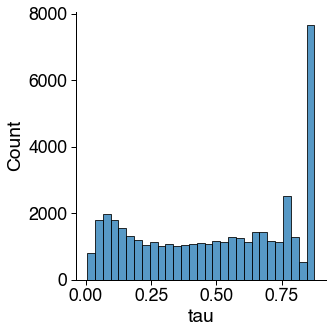

In [68]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', kind='hist')

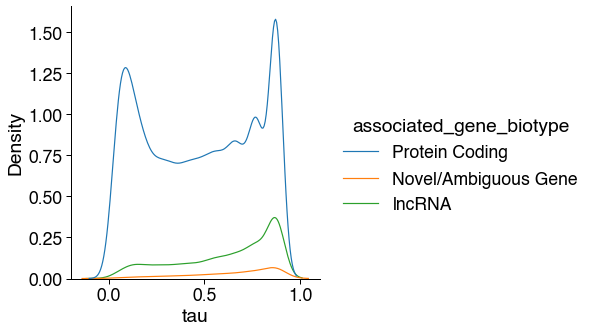

In [69]:
init_plot_settings(aspect='square')
sns.displot(tau_df, x='tau', hue='associated_gene_biotype', kind='kde')

In [70]:
tau_df['high_tau'] = tau_df.tau>=.8
tau_df.reset_index().groupby('high_tau').count()

,tid,tau,associated_gene_biotype
high_tau,,,
False,34273,34273,34273
True,8740,8740,8740


In [71]:
19365/(103154+19365)

0.15805711767154482

In [72]:
high_tau = tau_df.loc[tau_df.high_tau==True]

In [73]:
high_tau.head()
len(high_tau.index)
high_tau.reset_index(inplace=True)
high_tau.rename({'index':'tid'}, axis=1, inplace=True)

In [74]:
## what structural categories are high-tau transcripts?
# mt_df = pd.read_csv('../data/05_mastertable/master_table.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']

mt_df = pd.read_csv('../data/05_mastertable/poder_master_table.tsv', sep='\t')
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [75]:
len(mt_df.isoform.unique())

155875

In [76]:
# temp = mt_df.loc[mt_df.isoform.isin(high_tau.index.tolist())]
high_tau = high_tau.merge(mt_df[['isoform', 'structural_category']], 
                how='left',
                left_on='tid',
                right_on='isoform')
assert len(high_tau.loc[high_tau.isoform.isnull()].index) == \
       len(high_tau.loc[(high_tau.tid.str.startswith('ENST'))&\
                        (high_tau.isoform.isnull())].index)

In [77]:
# now we can assume everything that's null is FSM
high_tau.loc[high_tau.structural_category.isnull(), 'structural_category'] = 'FSM'

In [78]:
c_dict, order = get_novelty_colors()

In [79]:
temp = high_tau[['structural_category', 'tid']].groupby('structural_category').count().rename({'tid':'n_t'}, axis=1).reset_index()

In [80]:
order

['FSM', 'ISM', 'NIC', 'NNC', 'Intergenic', 'Genic', 'Fusion', 'Antisense']

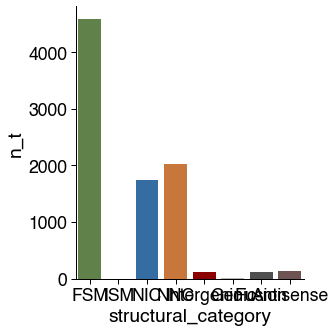

In [81]:
ax = sns.catplot(temp, y='n_t',x='structural_category',
            kind='bar', palette=c_dict, order=order, 
            saturation=1)

In [82]:
## BOX plots of expression of high tau transcripts across populations

In [83]:
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.head()
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

In [84]:
log_df = np.log2(df+1)
log_df = log_df.transpose()
log_df.reset_index(inplace=True)
log_df.rename({'index':'sample'}, axis=1, inplace=True)
log_df = log_df.merge(meta[['sample', 'population']], 
              how='left', on='sample')
# log_df.set_index('population', inplace=True)
log_df.index.name = ''
log_df.head()

,sample,ENST00000413811.3,transcript_6675,transcript_6676,transcript_6684,transcript_6687,transcript_7913,transcript_11363,transcript_11364,transcript_11365,...,transcript_323,transcript_324,transcript_325,transcript_326,transcript_327,transcript_190970,transcript_190971,transcript_328,transcript_329,population
,,,,,,,,,,,,,,,,,,,,,
0,YRI5,0.0,0.478421,0.967951,0.258952,0.000000,0.00000,0.574507,0.450883,0.166448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,YRI
1,YRI6,0.0,0.000000,0.524843,1.166844,0.000000,0.00000,0.538834,0.294428,0.154713,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,YRI
2,YRI7,0.0,0.634343,1.127092,0.705864,0.000000,0.00000,0.529828,0.289101,0.314512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,YRI
3,HAC1,0.0,0.172587,0.813163,0.000000,0.078001,0.06995,0.548518,0.072309,0.324798,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035399,HAC
4,HAC2,0.0,0.471429,1.351063,0.634301,0.000000,0.00000,0.773998,0.131049,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122673,HAC


In [85]:
log_df = log_df.melt(id_vars=['sample', 'population'],
            var_name='tid', value_name='log2tpm')

In [86]:
log_df.head()

,sample,population,tid,log2tpm
0,YRI5,YRI,ENST00000413811.3,0.0
1,YRI6,YRI,ENST00000413811.3,0.0
2,YRI7,YRI,ENST00000413811.3,0.0
3,HAC1,HAC,ENST00000413811.3,0.0
4,HAC2,HAC,ENST00000413811.3,0.0


In [87]:
def plot_thing(df, tid):
    temp = df.loc[df.tid==tid]
    ax = sns.catplot(temp, kind='box',
                     x='population', y='log2tpm',
                    palette=c_dict, order=order)
    ylabel = 'log2(transcript TPM + 1)'
    xlabel = ''
    ax.set(ylabel=ylabel, xlabel=xlabel)

In [88]:
c_dict, order = get_population_colors()

In [89]:
high_tau.loc[high_tau.tau<0.85]

,tid,tau,associated_gene_biotype,high_tau,isoform,structural_category
10,transcript_13302,0.810044,Protein Coding,True,transcript_13302,FSM
11,transcript_3353,0.805033,Protein Coding,True,transcript_3353,FSM
24,transcript_7183,0.802494,Protein Coding,True,transcript_7183,FSM
44,transcript_7702,0.806948,Protein Coding,True,transcript_7702,NIC
48,transcript_7055,0.847746,Protein Coding,True,transcript_7055,NNC
...,...,...,...,...,...,...
8687,transcript_376572,0.839219,lncRNA,True,transcript_376572,FSM
8694,transcript_377136,0.805280,lncRNA,True,transcript_377136,FSM
8725,transcript_190251,0.810938,lncRNA,True,transcript_190251,FSM
8726,transcript_190258,0.803610,lncRNA,True,transcript_190258,FSM


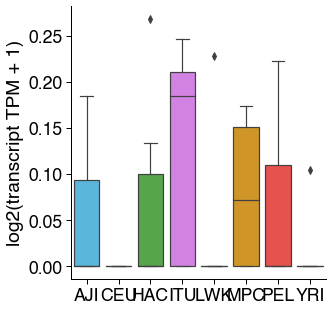

In [90]:
tid = 'transcript_8891'
plot_thing(log_df, tid)

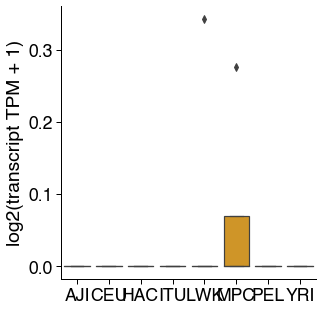

In [91]:
tid = 'transcript_2444'
plot_thing(log_df, tid)

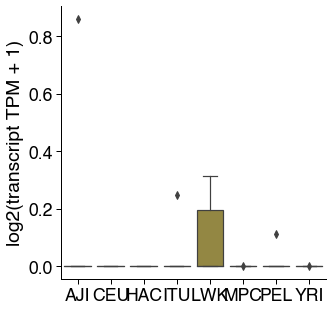

In [92]:
plot_thing(log_df, 'transcript_14253')

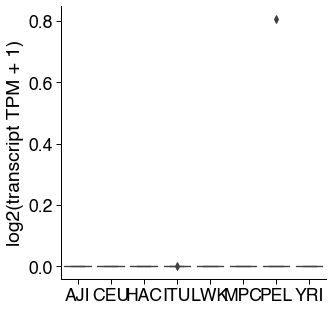

In [93]:
plot_thing(log_df, 'ENST00000689971.1')

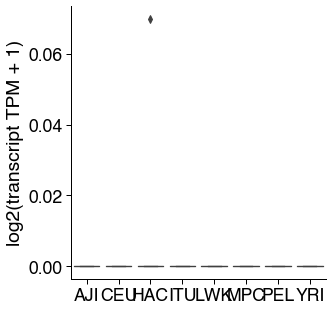

In [94]:
plot_thing(log_df, 'transcript_7913')